# Prophet Forecasting

## Set up

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet

In [2]:
# Importing the dataset
df = pd.read_csv('data/recruited_daily.csv')
df.head()

,date,Patients Recruited
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


## Preprocessing

In [3]:
# Change dates to datetime objects
df['date'] = pd.to_datetime(df['date'])
df.dtypes

date                  datetime64[ns]
Patients Recruited             int64
dtype: object

In [4]:
# Rename column names to 'ds' for the dates and 'y' for the values.
# This is for use with prophet
df.columns = ['ds', 'y']

df.head()

,ds,y
0,2021-01-07,1
1,2021-01-10,2
2,2021-01-11,2
3,2021-01-12,9
4,2021-02-11,6


In [5]:
# Creating a train-test split for cross validation
# Dates start at Jan 2021 and end Dec 2022 
cut_off_date = '2022-07-01'

# Splitting the dataset based on the above cut off date
train_df = df.loc[df['ds'] < cut_off_date]
test_df = df.loc[df['ds'] >= cut_off_date]

# Output some metrics about the split

train_df_len = train_df.shape[0]
test_df_len = test_df.shape[0]
print(f"length of train :{train_df_len}, length of test: {test_df_len}")
print(f"percentage of data = { round((train_df_len/df.shape[0]) *100)}% train / { round((test_df_len/df.shape[0]) *100)}% test")
print(f"number of months in test: { (test_df['ds'].max() - test_df['ds'].min()) /np.timedelta64(1, 'M') }")

length of train :221, length of test: 64
percentage of data = 78% train / 22% test
number of months in test: 5.2567814534179345


In [6]:
# Create a new dataframe with resampled dates as monthly aggregates

# Function will take a dataframe in the format that prophet requires with columns titled 'ds' and 'y' for dates and values
# Function will return dataframe with monthly aggregated dates
def month_resample(data):
    resampled_data = data.set_index('ds').resample('M').sum()
    resampled_data = resampled_data.reset_index()
    
    return resampled_data


train_df_monthly = month_resample(train_df)
test_df_monthly = month_resample(test_df)

test_df_monthly.tail()

,ds,y
0,2022-07-31,112
1,2022-08-31,107
2,2022-09-30,50
3,2022-10-31,50
4,2022-11-30,39


## Forecasting

**To-do:** <br>
1. Compare those predictions with the actual values. Use RMSE 
2. Then forecast for a prediction 6-12 months beyond the last month in the test dataset.
3. End with some commentary about the predictions and a mention of the caveats.
<br><br><br>

**Things to understand:**
- What is an additive model
- what are the alternatives to prophet and why choose them instead of prophet or vice versa.
- Why doesn't prophet require preprocessing?
- How to use the holidays feature of prophet 

In [10]:
# Create an instance of an 'empty' model
m = Prophet(interval_width=0.95)

# Train the model
model = m.fit(train_df_monthly)

# Creating the future dates to forecast
future_dates = model.make_future_dataframe(periods=6, freq='M')
future_dates

13:16:34 - cmdstanpy - INFO - Chain [1] start processing
13:16:34 - cmdstanpy - INFO - Chain [1] done processing


,ds
0,2021-01-31
1,2021-02-28
2,2021-03-31
3,2021-04-30
4,2021-05-31
5,2021-06-30
6,2021-07-31
7,2021-08-31
8,2021-09-30
9,2021-10-31


In [8]:
# Forecasting output
forecast = model.predict(future_dates)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-01-31,-16.867950,-65.752656,35.228382,-16.867950,-16.867950,0.0,0.0,0.0,0.0,0.0,0.0,-16.867950
1,2021-02-28,-7.284635,-51.621635,39.740715,-7.284635,-7.284635,0.0,0.0,0.0,0.0,0.0,0.0,-7.284635
2,2021-03-31,3.325464,-45.742347,49.842558,3.325464,3.325464,0.0,0.0,0.0,0.0,0.0,0.0,3.325464
3,2021-04-30,13.593302,-32.084676,61.181828,13.593302,13.593302,0.0,0.0,0.0,0.0,0.0,0.0,13.593302
4,2021-05-31,24.203401,-23.171603,73.991388,24.203401,24.203401,0.0,0.0,0.0,0.0,0.0,0.0,24.203401


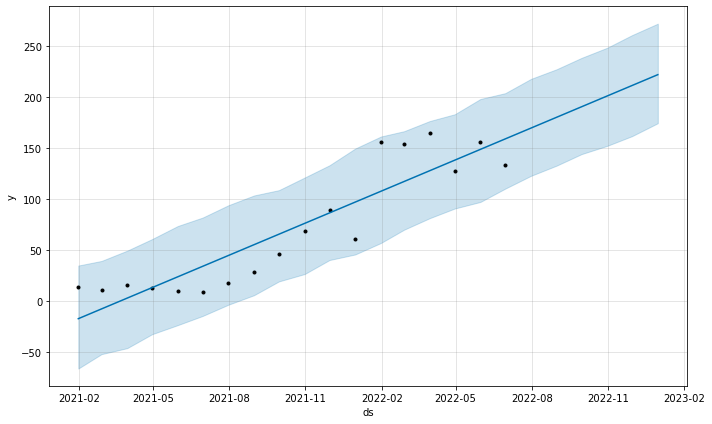

In [15]:
# Forecast plot
plot1 = model.plot(forecast)

plt.show()

Some notes about what Prophet is doing: <br>
You'll note that I've made no attempt at making the data stationary before shoving it into a model, but apparently the model that prophet is using isn't concerned with stationarity... <br>
*"No. Stationarity is an important condition for some other time series forecasting algorithms such as ARMA or ARIMA, but prophet assumes nothing about stationarity. Prophet rather makes use of features like trend or seasonality, which stationary data by definition do not have"*
<br><br>
I'll probably want to learn how to intepret the plot and dataframe that prophet has output above, next.
...

## Key Improvements & Caveats